 # Quick comparison of PCN and CPCN on MNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch

from tqdm.notebook import tqdm

from cpcn import LinearCPCNetwork, PCNetwork, load_mnist, train

 ## Setup

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders, by default
dataset = load_mnist(n_train=5000, n_validation=1000, device=device)

 ## Train PCN

In [3]:
n_epochs = 50
dims = [784, 50, 20, 10]
it_inference = 50
lr_inference = 0.1

torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation=lambda _: _,
    lr_inference=lr_inference,
    it_inference=it_inference,
    variances=1.0,
)
net = net.to(device)

results = train(
    net,
    n_epochs,
    dataset["train"],
    dataset["validation"],
    classifier="linear",
    progress=tqdm,
)

  0%|          | 0/50 [00:00<?, ?it/s]

 ### Show PCN learning curves

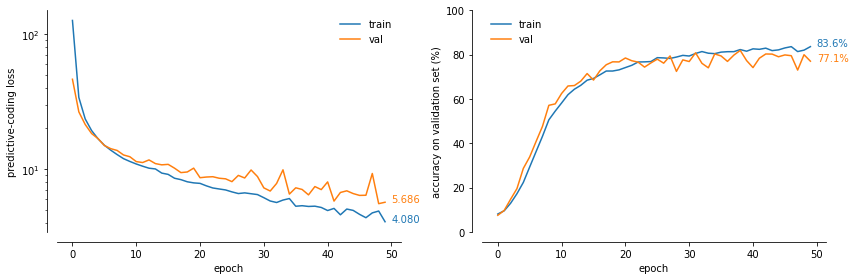

In [4]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(results.train.pc_loss, label="train")
    ax1.semilogy(results.validation.pc_loss, label="val")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)
    last_loss = results.train.pc_loss[-1]
    ax1.annotate(f"{last_loss:.3f}", (len(results.train.pc_loss), last_loss), c="C0")
    last_loss = results.validation.pc_loss[-1]
    ax1.annotate(
        f"{last_loss:.3f}", (len(results.validation.pc_loss), last_loss), c="C1"
    )

    ax2.plot(100 * results.train.accuracy, label="train")
    ax2.plot(100 * results.validation.accuracy, label="val")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy on validation set (%)")
    ax2.legend(frameon=False)
    last_acc = 100 * results.train.accuracy[-1]
    ax2.annotate(f"{last_acc:.1f}%", (len(results.train.accuracy), last_acc), c="C0")
    last_acc = 100 * results.validation.accuracy[-1]
    ax2.annotate(
        f"{last_acc:.1f}%", (len(results.validation.accuracy), last_acc), c="C1"
    )
    ax2.set_ylim(0, 100)

 ## Train CPCN

In [5]:
z_it = 100
z_lr = 0.05

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

cpcn_net = LinearCPCNetwork(
    dims, z_lr=z_lr, z_it=z_it, g_a=g_a, g_b=g_b, c_m=0, l_s=g_b
)
cpcn_net = cpcn_net.to(device)

cpcn_results = train(
    cpcn_net,
    n_epochs,
    dataset["train"],
    dataset["validation"],
    classifier="linear",
    progress=tqdm,
)

  0%|          | 0/50 [00:00<?, ?it/s]

 ### Show CPCN learning curves

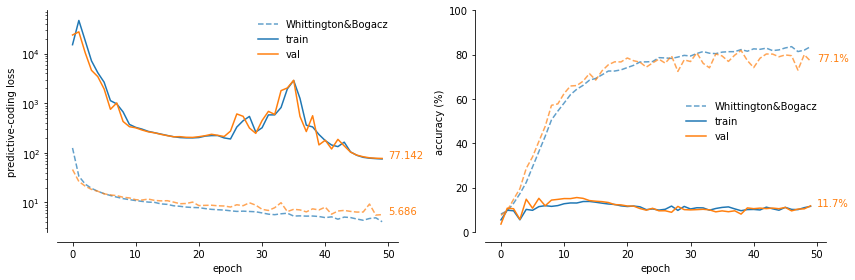

In [6]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(
        results.train.pc_loss, c="C0", ls="--", alpha=0.7, label="Whittington&Bogacz"
    )
    ax1.semilogy(results.validation.pc_loss, c="C1", ls="--", alpha=0.7)

    ax1.semilogy(cpcn_results.train.pc_loss, c="C0", label="train")
    ax1.semilogy(cpcn_results.validation.pc_loss, c="C1", label="val")

    last_loss = results.validation.pc_loss[-1]
    ax1.annotate(
        f"{last_loss:.3f}", (len(results.validation.pc_loss), last_loss), c="C1"
    )
    last_loss = cpcn_results.validation.pc_loss[-1]
    ax1.annotate(
        f"{last_loss:.3f}", (len(cpcn_results.validation.pc_loss), last_loss), c="C1"
    )

    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)

    ax2.plot(
        100 * results.train.accuracy,
        c="C0",
        ls="--",
        alpha=0.7,
        label="Whittington&Bogacz",
    )
    ax2.plot(100 * results.validation.accuracy, c="C1", ls="--", alpha=0.7)
    ax2.plot(100 * cpcn_results.train.accuracy, c="C0", label="train")
    ax2.plot(100 * cpcn_results.validation.accuracy, c="C1", label="val")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy (%)")

    last_acc = 100 * results.validation.accuracy[-1]
    ax2.annotate(
        f"{last_acc:.1f}%", (len(results.validation.accuracy), last_acc), c="C1"
    )
    last_acc = 100 * cpcn_results.validation.accuracy[-1]
    ax2.annotate(
        f"{last_acc:.1f}%", (len(cpcn_results.validation.accuracy), last_acc), c="C1"
    )

    ax2.legend(frameon=False)
    ax2.set_ylim(0, 100)